In [1]:
# %matplotlib notebook
import NN_Module_CPU as nnm
import torch
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
from pandas import read_csv

In [2]:
# Functions

# Initializes graph_data
def init_graph_data(graph_data, total_num, epochs):
    graph_data['train_loss_vals'] = np.zeros(epochs)
    graph_data['train_loss_epochs'] = np.zeros(epochs)
    graph_data['test_loss_vals'] = np.zeros(epochs)
    graph_data['test_loss_epochs'] = np.zeros(epochs)
    graph_data['accu_vals'] = np.zeros(epochs)
    graph_data['accu_epochs'] = np.zeros(epochs)
    graph_data['time_vals'] = np.zeros(epochs)
    graph_data['time_epochs'] = np.zeros(epochs)
    graph_data['accu_out_vals'] = np.zeros(epochs * total_num)
    graph_data['accu_out_colors'] = np.full(epochs * total_num, 'r')
    graph_data['accu_out_epochs'] = np.zeros(epochs * total_num)
    graph_data['out_residual_vals'] = np.array([])
    graph_data['2D_residual_x'] = np.zeros(total_num)
    graph_data['2D_residual_y'] = np.zeros(total_num)
    graph_data['weights'] = np.array([])
    graph_data['biases'] = np.array([])

# Initializes analysis_data
def init_analysis_data(analysis_data):
    analysis_data['nodes'] = []
    analysis_data['layers'] = []
    analysis_data['epochs'] = []
    analysis_data['time'] = []
    analysis_data['accuracy'] = []

# Train network
def train_network(model, hidden_nodes, hidden_layers, inputs, outputs, test_inputs, test_outputs, graph_data, analysis_data, miniBatchSize = 100., num_epochs = 500, show_progress = True):
    # Useful information
    total_num = torch.numel(test_outputs)
    N = inputs.shape[1]

    # Get ready to train
    start_time = time.time()
    model.train()

    # Break the list up into smaller batches for more efficient training
    numMiniBatch = int(math.floor(inputs.shape[0]/miniBatchSize))
    inputMiniBatches = inputs.chunk(numMiniBatch)
    outputMiniBatches = outputs.chunk(numMiniBatch)

    # Set up the training functions
    lossFunc = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

    # Initialize graph data
    init_graph_data(graph_data, total_num, num_epochs)

    # Actually train
    for epoch in range(num_epochs):
        # Everything that needs to be done every epoch
        with torch.no_grad():
            model.eval()
            # Data for the accuracy plots
            prediction_temp = model(test_inputs)
            score_temp = nnm.v_accu_test(prediction_temp.cpu().detach().numpy(), test_outputs.cpu().detach().numpy())
            graph_data['accu_vals'][epoch] = np.sum(score_temp) / total_num
            graph_data['accu_epochs'][epoch] = epoch
            for i in range(total_num):
                if (score_temp[i] == 1):
                    graph_data['accu_out_colors'][i + epoch*total_num] = 'b'
                graph_data['accu_out_epochs'][i + epoch*total_num] = epoch
                graph_data['accu_out_vals'][i + epoch*total_num] = test_outputs[i]

            # Data for the other plots
            train_total_prediction_temp = model(inputs)
            train_total_loss_temp = lossFunc(train_total_prediction_temp, outputs).item()
            test_total_prediction_temp = model(test_inputs)
            test_total_loss_temp = lossFunc(test_total_prediction_temp, test_outputs).item()
            graph_data['train_loss_vals'][epoch] = train_total_loss_temp
            graph_data['train_loss_epochs'][epoch] = epoch
            graph_data['test_loss_vals'][epoch] = test_total_loss_temp
            graph_data['test_loss_epochs'][epoch] = epoch
            graph_data['time_vals'][epoch] = time.time() - start_time
            graph_data['time_epochs'][epoch] = epoch

        # Things that need to be done every 10 epochs
        if epoch%10 == 0:
            if show_progress:
                print('=>Starting {}/{} epochs.'.format(epoch+1,num_epochs))
            
            with torch.no_grad():
                model.eval()
        
        # Things that need to be done every 50 epochs
        if epoch%50 == 0 and epoch != 0:
            with torch.no_grad():
                model.eval()
                analysis_data['nodes'].append(hidden_nodes)
                analysis_data['layers'].append(hidden_layers)
                analysis_data['epochs'].append(epoch)
                analysis_data['time'].append(graph_data['time_vals'][epoch])
                analysis_data['accuracy'].append(graph_data['accu_vals'][epoch])
                
                
        model.train()
                
        for minibatch in range(numMiniBatch):
            prediction = model(inputMiniBatches[minibatch])
            loss = lossFunc(prediction,outputMiniBatches[minibatch])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Data for the residual plots
    model.eval()
    prediction_temp = model(test_inputs)
    residual = test_outputs - prediction_temp
    graph_data['out_residual_vals'] = np.append(graph_data['out_residual_vals'], residual.cpu().detach().numpy())
    for i in range(total_num):
        graph_data['2D_residual_x'][i] = test_inputs[i][0]
        graph_data['2D_residual_y'][i] = test_inputs[i][1]
    
    # Data for the weights and biases histograms
    model_param  = model.state_dict()
    for key in model_param.keys():
        if 'weight' in key:
            graph_data['weights'] = np.append(graph_data['weights'], model_param[key].cpu().detach().numpy().flatten())
        elif 'bias' in key:
            graph_data['biases'] = np.append(graph_data['biases'], model_param[key].cpu().detach().numpy().flatten())

    print ('Training done!')
    #print ('--- %s seconds ---' % (time.time() - start_time))

# Target function to approximate
def target_func(input):
    return input[0]**2 + input[1]

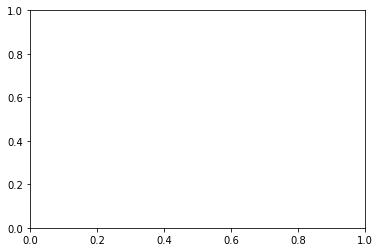

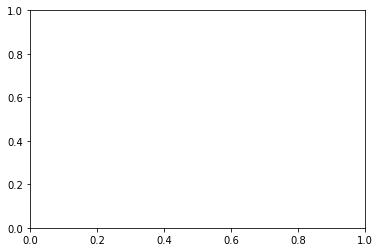

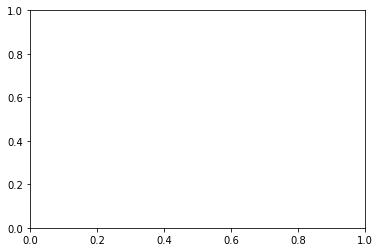

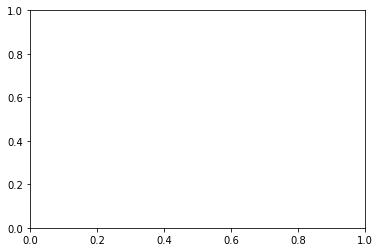

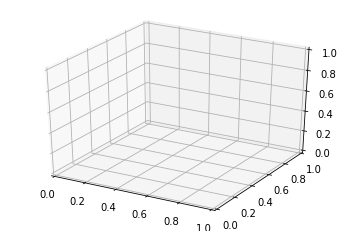

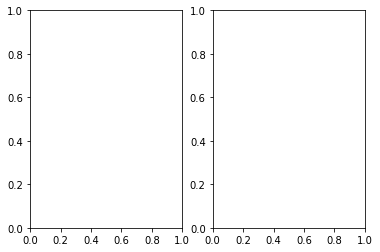

In [3]:
# Notebook

# Global variables
graph_data = {}
analysis_data = {} # Stores data of hyperparameters vs. performance
init_analysis_data(analysis_data)

# set up graph for loss curve, accuracy curve
fig_loss, ax_loss = plt.subplots()
fig_accu, ax_accu = plt.subplots()
fig_accu_out, ax_accu_out = plt.subplots()
fig_out_residual, ax_out_residual = plt.subplots()
fig_2D_residual = plt.figure()
ax_2D_residual = fig_2D_residual.add_subplot(projection='3d')
fig_histograms, (ax_weights, ax_biases) = plt.subplots(nrows=1, ncols=2)

# Create a list of sets of N random numbers, the training set
N = 2
train_size = 10000
test_size = 1000

### Standardize
inputs = (10 * torch.rand((train_size,N),dtype=torch.float32) - 5)
outputs = torch.zeros((train_size, 1))
for i in range(train_size):
    outputs[i] = torch.tensor([target_func(inputs[i])])

# create a test set
test_inputs = (10 * torch.rand((test_size,N),dtype=torch.float32) - 5) # Uniform
# test_inputs = torch.randn((test_size,N),dtype=torch.float32) # Normal
test_outputs = torch.zeros((test_size, 1))
for i in range(test_size):
    test_outputs[i] = torch.tensor([target_func(test_inputs[i])])

# Create a model
hidden_nodes = 100
hidden_layers = 1
batch_size = 100
n_epochs = 500
model = nnm.create_model(inputs, outputs, hidden_nodes, hidden_layers)[0]

In [4]:
outputs.shape

torch.Size([10000, 1])

In [5]:
# Train the model
train_network(model, hidden_nodes, hidden_layers, inputs, outputs, test_inputs, test_outputs, graph_data, analysis_data, batch_size, n_epochs)

=>Starting 1/500 epochs.
=>Starting 11/500 epochs.
=>Starting 21/500 epochs.
=>Starting 31/500 epochs.
=>Starting 41/500 epochs.
=>Starting 51/500 epochs.
=>Starting 61/500 epochs.
=>Starting 71/500 epochs.
=>Starting 81/500 epochs.
=>Starting 91/500 epochs.
=>Starting 101/500 epochs.
=>Starting 111/500 epochs.
=>Starting 121/500 epochs.
=>Starting 131/500 epochs.
=>Starting 141/500 epochs.
=>Starting 151/500 epochs.
=>Starting 161/500 epochs.
=>Starting 171/500 epochs.
=>Starting 181/500 epochs.
=>Starting 191/500 epochs.
=>Starting 201/500 epochs.
=>Starting 211/500 epochs.
=>Starting 221/500 epochs.
=>Starting 231/500 epochs.
=>Starting 241/500 epochs.
=>Starting 251/500 epochs.
=>Starting 261/500 epochs.
=>Starting 271/500 epochs.
=>Starting 281/500 epochs.
=>Starting 291/500 epochs.
=>Starting 301/500 epochs.
=>Starting 311/500 epochs.
=>Starting 321/500 epochs.
=>Starting 331/500 epochs.
=>Starting 341/500 epochs.
=>Starting 351/500 epochs.
=>Starting 361/500 epochs.
=>Starting 3

In [6]:
# Graphing
ax_accu.plot(graph_data['accu_epochs'], graph_data['accu_vals'], 'b-')
ax_accu.set_xlabel('Epochs')
ax_accu.set_ylabel('Accuracy')
                                  
ax_accu_out.scatter(graph_data['accu_out_epochs'], graph_data['accu_out_vals'], c=graph_data['accu_out_colors'], s=1)
ax_accu_out.set_xlabel('Epochs')
ax_accu_out.set_ylabel('Outputs (Red=inaccurate, Blue=accurate)')

train_loss_line, = ax_loss.plot(graph_data['train_loss_epochs'], graph_data['train_loss_vals'], 'b-', linewidth=1)
test_loss_line, = ax_loss.plot(graph_data['test_loss_epochs'], graph_data['test_loss_vals'], 'g-', linewidth=1)
ax_loss.legend([train_loss_line, test_loss_line], ['Train', 'Test'])
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Loss (MSE)')
ax_loss.set_yscale('log')

ax_out_residual.scatter(test_outputs.cpu().detach().numpy(), graph_data['out_residual_vals'], c='b', s=1)
ax_out_residual.set_xlabel('True Outputs')
ax_out_residual.set_ylabel('Residual (actual - prediction)')

ax_2D_residual.scatter(graph_data['2D_residual_x'], graph_data['2D_residual_y'], graph_data['out_residual_vals'], c='b', s=1)
ax_2D_residual.set_xlabel('x-coordinate Input')
ax_2D_residual.set_ylabel('y-coordinate Input')
ax_2D_residual.set_zlabel('Residual (actual - prediction)')

ax_weights.hist(graph_data['weights'], color='b')
ax_weights.set_xlabel('Weights')
ax_weights.set_ylabel('# of Instances')

ax_biases.hist(graph_data['biases'], color='b')
ax_biases.set_xlabel('Biases')
ax_biases.set_ylabel('# of Instances')

Text(185.81818181818176, 0.5, '# of Instances')

In [7]:
test_inputs.cpu().detach().numpy()

array([[-1.1323106 , -0.2942176 ],
       [ 0.79127073, -0.11424637],
       [ 2.4958286 , -0.18453598],
       ...,
       [ 1.4783401 , -1.980228  ],
       [ 0.5695038 , -1.2847161 ],
       [-2.9472451 ,  3.3793955 ]], dtype=float32)

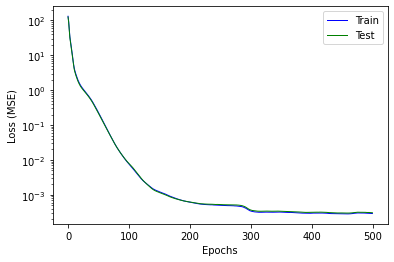

In [8]:
fig_loss

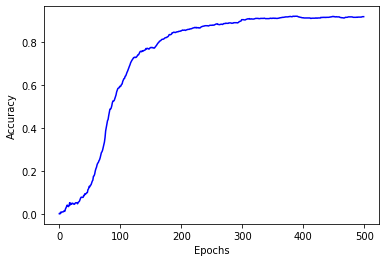

In [9]:
fig_accu

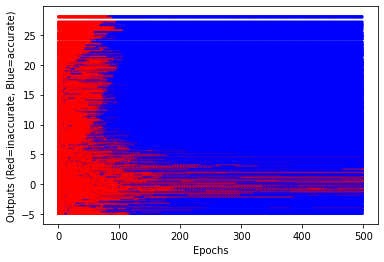

In [10]:
fig_accu_out

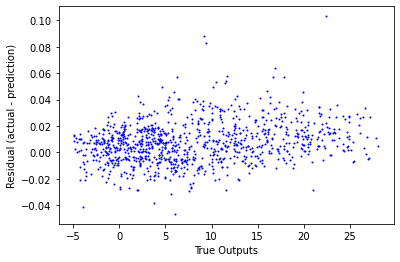

In [11]:
fig_out_residual

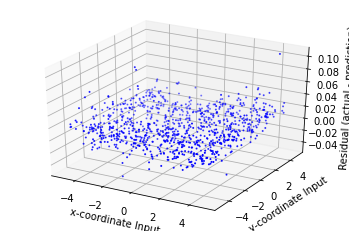

In [12]:
fig_2D_residual

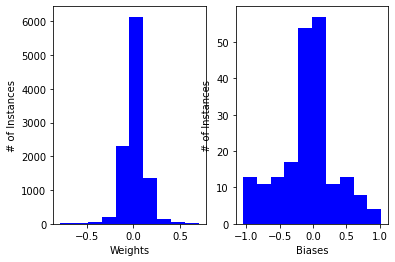

In [13]:
fig_histograms

In [24]:
# Save graphs
fig_loss.savefig('loss.pdf')
fig_accu.savefig('accu.pdf')
fig_accu_out.savefig('accu_out.pdf')
fig_out_residual.savefig('out_residual.pdf')
fig_2D_residual.savefig('2D_residual.pdf')
fig_histograms.savefig('histograms.pdf')

In [4]:
# Analysis
param_list = [[1000, 2, 501]]#[100, 1, 501], [200, 1, 501], [300, 1, 501], [100, 2, 501], [200, 2, 501], [300, 2, 501]] # [nodes, layers, epochs]
for i in param_list:
    model = nnm.create_model(inputs, outputs, i[0], i[1])[0]
    train_network(model, i[0], i[1], inputs, outputs, test_inputs, test_outputs, graph_data, analysis_data, batch_size, i[2], False)

Training done!


In [5]:
# Send data to be displayed
df = pd.DataFrame(data=analysis_data)

In [6]:
# Display analysis data
### Make graphs
print(df)

   nodes  layers  epochs         time  accuracy
0   1000       2      50   290.884426     0.914
1   1000       2     100   586.434829     0.902
2   1000       2     150   867.763612     0.869
3   1000       2     200  1161.077869     0.982
4   1000       2     250  1462.268719     0.861
5   1000       2     300  1769.255908     0.982
6   1000       2     350  2080.209445     0.845
7   1000       2     400  2402.457459     0.919
8   1000       2     450  2747.650542     0.954
9   1000       2     500  3043.171129     0.906


In [17]:
# Uploads existing data and adds it to working dataset
# file_upload = read_csv("NN_Test_Data_1.csv")
# print(file_upload)
# df = df.append(file_upload)

In [18]:
# Saves run data as csv file
df.to_csv("NN_Test_Data_1.csv", index=False)